## SmartSilent - A machine learning algorithm to predict behavior.
### Author: Duncan Cameron-Steinke

Firstly a fictional list of text messages is created

In [26]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pylab as plt
import seaborn
import string

# Defining the list of contacts
Names = ['Friend', 'Family', 'Colleague', 'Aquaintance']
MessagesFile = pd.DataFrame( columns = ['Name','Time','Received'])

Above a list of contacts labeled "Names" is defined, and the messages file format is defined.

Below, beginning at time T, a name is randomely selected from "Names" array and saved as an incoming text.

In [7]:
T = pd.Timestamp(2018,1,1)
j = -1
for i in range(1000):
    j = j + 1
    # A text is received from a random person
    N = Names[np.random.randint(0,4)] 
    MessagesFile.loc[j, 'Name'] = N 
    MessagesFile.loc[j, 'Time'] = T 
    MessagesFile.loc[j, 'Received'] = True # Wether the text is incoming or outgoing
    
    # A random response time is chosen on the interval of 0 and 2 hours.
    Delta = pd.Timedelta(hours=np.random.randint(0,2), minutes = np.random.randint(0,60))
    
    j = j + 1
    # For each contact there is a different probability for a response occuring.
    # In addition, 'Friend' has a 30 minute shorter average response time, and aquaintance
    # has a 30 minute longer average response time
    if N == 'Friend' and np.random.random_sample() > 0.25:
        Delta = Delta - pd.Timedelta(minutes = 30)
        T = T + Delta 
        MessagesFile.loc[j] = ('Friend', T, False)
        
    elif N == 'Family' and np.random.random_sample() > 0.25:
        T = T + Delta
        MessagesFile.loc[j] = ('Family', T, False)

    elif N == 'Colleague' and np.random.random_sample() > 0.5:
        T = T + Delta
        MessagesFile.loc[j] = ('Colleague', T, False)

    elif N == 'Aquaintance' and np.random.random_sample() > 0.75:
        Delta = Delta + pd.Timedelta(minutes = 30)
        T = T + Delta 
        MessagesFile.loc[j] = ('Aquaintance', T, False)
    else:
        T = T + Delta
        j = j - 1

The messages data set is finished being constructed and includes: The person who sent/received the text, the time at which the text was sent/received, the status of whether it is received or sent (received = true).

In [11]:
MessagesFile.head() 

,Name,Time,Received
0,Colleague,2018-01-01 00:00:00,True
1,Colleague,2018-01-01 01:12:00,False
2,Friend,2018-01-01 01:12:00,True
3,Friend,2018-01-01 00:49:00,False
4,Friend,2018-01-01 00:49:00,True


While creating the dataset the same total number of texts was received from each contact, however not all contacts had the same likelyhood of soliciting a response. If a text is responded to in less then an hour, the text status is considered "responded".

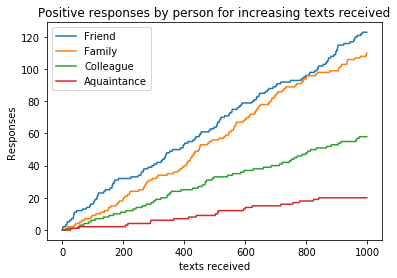

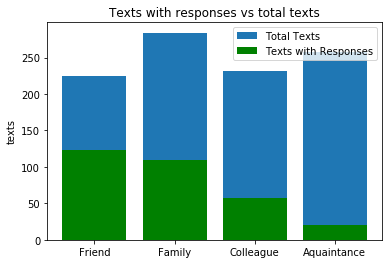

In [15]:
Cut_off = pd.Timedelta(minutes = 60)

# This dataFrame is used solely for plotting
NamesPlot = ['Friend','FriendTotal','Family','FamilyTotal','Colleague','ColleagueTotal','Aquaintance','AquaintanceTotal']
Plot = pd.DataFrame(data = np.zeros((1,len(NamesPlot))), columns = NamesPlot)
j = 0

# Searches through each message, if the condition that a response happened is 
# True, then the total responses for that name is updated.
for i in range(1,len(MessagesFile)-1):    
    if MessagesFile.loc[i, 'Received'] == True:
        j = j + 1

        N = MessagesFile.loc[i, 'Name']
        Plot.loc[j] = Plot.loc[j-1]
        time_delay = MessagesFile.loc[i+1, 'Time'] - MessagesFile.loc[i, 'Time']
        if MessagesFile.loc[i+1,'Received'] == False and time_delay < Cut_off:
            response = True
            Plot.loc[j, N] = Plot.loc[j, N] + 1
            Plot.loc[j, N + 'Total'] = Plot.loc[j, N + 'Total'] + 1
            
        else:
            response = False
            Plot.loc[j, N + 'Total'] = Plot.loc[j, N + 'Total'] + 1
            
    else:
        received = False

plt.plot(Plot[Names])
plt.legend(Names)
plt.title("Positive responses by person for increasing texts received")
plt.ylabel("Responses")
plt.xlabel("texts received")
plt.show()

PlotData = Plot.loc[998]
plt.bar(Names,PlotData[['FriendTotal','FamilyTotal','ColleagueTotal','AquaintanceTotal']], label = 'Total Texts')
plt.bar(Names,PlotData[Names], color = 'g', label = 'Texts with Responses')
plt.legend()
plt.ylabel("texts")
plt.title("Texts with responses vs total texts")
plt.show()

* Figure 1: The total number of texts responded to by contact vs total number of texts received
* Figure 2: the percentage of texts responded to by contact

### Using the above messages file to determine posterior probability of a response

In [17]:
### Storing data

Contacts = pd.DataFrame(data = {'Names': Names})
# App starts here:

Contacts['Returns'] = np.zeros(len(Contacts.Names))
# Returns is the total value of texts replied to per contact
Contacts['Total'] = np.zeros(len(Contacts.Names))
# Total is the number of texts received per contact
Contacts['Bayes Probability']= np.zeros(len(Contacts.Names))
# Bayes Probability uses the data stored on each contact (ie. Returns and total)
# and uses these values to calculate the probability of wanting to respond to that person.

Contacts['Likelihood'] = np.zeros(len(Contacts.Names))
# Likelihood is the is the percentage of texts responded to by each contact.
Contacts['Evidence'] = np.zeros(len(Contacts.Names))
# Evidence is the confidence in the likelihood value
Contacts['Last'] = np.zeros(len(Contacts.Names))
# Last stores the number of the last text received from that person
Contacts['Modified Bayes Probabiliy'] = np.zeros(len(Contacts.Names))
# "Modified Bayes Probability" is the probability of a text being returned.
# It is calculated using "likelihood" and "Evidence" neither of which collect
# absolute data.
Contacts.head()

,Names,Returns,Total,Bayes Probability,Likelihood,Evidence,Last,Modified Bayes Probabiliy
0,Friend,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Family,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Colleague,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aquaintance,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Above the necessary classifiers are defined that will be used for calculating posterior Bayes probability.

In [18]:
Cut_off = pd.Timedelta(minutes = 60)
TotalSent = 0
Prior = 1

# Collecting Data
def Increase_TotalSent(TotalSent):
    TotalSent = TotalSent+1
    return TotalSent

def Increase_Returns(name):
    Returns = Contacts.loc[Contacts['Names'] == name, 'Returns']
    Returns = Returns + 1
    Contacts.loc[Contacts['Names'] == name, 'Returns'] = Returns

def Increase_TotalReceived(name):
    Total = Contacts.loc[Contacts['Names'] == name, 'Total']
    Total = Total + 1
    Contacts.loc[Contacts['Names'] == name, 'Total'] = Total
    
# Not directly collecting data, just tracking probability
def Increase_Prior(Prior, n):
    Prior = (Prior*n+1)/(n+1)
    return Prior
    
def Increase_Likelihood(name, n, Prior):   
    Last = Contacts.loc[Contacts['Names'] == name, 'Last']
    S = n*Prior
    Likelihood = Contacts.loc[Contacts['Names'] == name, 'Likelihood']
    Likelihood = (Likelihood*Last + 1)/S
    Contacts.loc[Contacts['Names'] == name, 'Likelihood'] = Likelihood

def Increase_Evidence(name, n):
    Evidence = Contacts.loc[Contacts['Names'] == name, 'Evidence']
    Last = Contacts.loc[Contacts['Names'] == name, 'Last']
    Evidence = (Evidence*Last + 1)/(n+1)
    Contacts.loc[Contacts['Names'] == name, 'Evidence'] = Evidence
    
def Update_last(name, count):
    Contacts.loc[Contacts['Names'] == name, 'Last'] = count

# Iterate through all past messages to quantify trends
count = 0
for i in range(0,len(MessagesFile)-1):    
    if MessagesFile.loc[i, 'Received'] == True:
        count = count + 1

        N = MessagesFile.loc[i, 'Name']

        time_delay = MessagesFile.loc[i+1, 'Time'] - MessagesFile.loc[i, 'Time']
        if MessagesFile.loc[i+1,'Received'] == False and time_delay < Cut_off:
            response = True

            TotalSent = Increase_TotalSent(TotalSent)
            Increase_Returns(N)
            Increase_TotalReceived(N)

            Prior = Increase_Prior(Prior, count)
            Increase_Likelihood(N, count, Prior)
            Increase_Evidence(N, count)
            Update_last(N, count)
            
        else:
            response = False
            Update_last(N, count)
            Increase_TotalReceived(N)
            Increase_Evidence(N, count)

    else:
        received = False
Contacts.head()

,Names,Returns,Total,Bayes Probability,Likelihood,Evidence,Last,Modified Bayes Probabiliy
0,Friend,123.0,225.0,0.0,0.293390,0.315057,985.0,0.0
1,Family,110.0,284.0,0.0,0.229068,0.404276,999.0,0.0
2,Colleague,58.0,232.0,0.0,0.138340,0.406771,998.0,0.0
3,Aquaintance,20.0,258.0,0.0,0.079615,0.638745,996.0,0.0


### Each text is screened and data is stored in two ways:
* For calculating Bayes probability it is necessary to know both the total number of texts received by each contact, as well as the total number of true reponses sent to each contact, this might be considered intrusive data colection.
* For calculating Modified Bayes Probability, "Likelihood" and "Evidence" data is collected. These values are updated with each iteration and so does not require keeping track of past text information.

In [22]:
# Use information from past texts to predict future probability
for Name in Names:
    Returns = Contacts.loc[Contacts['Names'] == Name, 'Returns']
    Total = Contacts.loc[Contacts['Names'] == Name, 'Total']
    Likelihood = Contacts.loc[Contacts['Names'] == Name, 'Likelihood']
    Evidence = Contacts.loc[Contacts['Names'] == Name, 'Evidence']

    Contacts.loc[Contacts['Names'] == Name, "Bayes Probability"]\
    = (Returns * TotalSent)/ (Total * Total)

    Contacts.loc[Contacts['Names'] == Name, "Modified Bayes Probabiliy"]\
    = (Likelihood * Prior)/ Evidence

print(Contacts[["Names","Bayes Probability", "Modified Bayes Probabiliy"]])

         Names  Bayes Probability  Modified Bayes Probabiliy
0       Friend           0.755615                   0.931227
1       Family           0.424147                   0.566614
2    Colleague           0.335129                   0.340094
3  Aquaintance           0.093444                   0.124644


### similar results are acheived using either method of bayes calculation
#### Based on the results of the Modifed Bayes Probability it would be possible to adjust the phones ringer to only receive texts from contacts with a high probability of eliciting a response:

In [24]:
def Incoming_Text(Name):
    Posterior = Contacts.loc[Contacts['Names'] == Name, 'Modified Bayes Probabiliy']
    if  0.5 < float(Posterior):
        print("Message received from "+ Name +", ringer is on")
    else:
        print('Message received from '+ Name + ', ringer is off')
Incoming_Text("Friend")

Message received from Friend, ringer is on


In [25]:
Incoming_Text("Colleague")

Message received from Colleague, ringer is off
